In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import fastreg.design as frd
import fastreg.linear as frl
import fastreg.general as frg
import fastreg.genjax as frx
%matplotlib inline

### Generate Data

In [2]:
st = np.random.RandomState(89320432)
N, K1, K2 = 1_000_000, 10, 100

In [3]:
df0 = pd.DataFrame({
    'id1': st.randint(K1, size=N),
    'id2': st.randint(K2, size=N),
    'x1': st.randn(N),
    'x2': st.randn(N)
})
df0['y'] = 5 + 3*df0['x1'] + 2*df0['x2'] + st.randn(N)
df0['lEp'] = 0.6*df0['x1'] + 0.2*df0['x2']
df0['Ep'] = np.exp(df0['lEp'])
df0['p'] = np.random.poisson(df0['Ep'])
df0['p0'] = np.where(st.rand(N) < 0.2, 0, df0['p'])
df0.head()

,id1,id2,x1,x2,y,lEp,Ep,p,p0
0,4,99,-0.232286,-1.106499,4.721238,-0.360671,0.697208,1,1
1,8,98,0.457063,0.585081,9.168498,0.391254,1.478834,1,0
2,8,73,0.761536,-0.705039,6.487252,0.315914,1.371512,1,1
3,8,40,-0.251006,-0.884939,1.583604,-0.327591,0.720657,0,0
4,6,90,-1.211539,1.763510,6.438151,-0.374222,0.687824,2,0


In [4]:
df = pd.DataFrame({
    'id1': st.randint(K1, size=N),
    'id2': st.randint(K2, size=N),
    'x1': st.randn(N),
    'x2': st.randn(N)
})
df['y'] = 5 + 3*df['x1'] + 2*df['x2'] + 0.1*df['id1'] + 0.01*df['id2'] + st.randn(N)
df['lEp'] = 0.6*df['x1'] + 0.2*df['x2'] + 0.2*df['id1']/100 + 0.5*df['id2']/100
df['Ep'] = np.exp(df['lEp'])
df['p'] = np.random.poisson(df['Ep'])
df.head()

,id1,id2,x1,x2,y,lEp,Ep,p
0,4,91,-1.568084,-0.302746,0.198134,-0.538400,0.583682,1
1,8,34,2.149949,0.738744,15.280657,1.623718,5.071913,11
2,4,85,0.270684,1.181311,9.546037,0.831672,2.297157,2
3,4,21,-0.035878,-0.017614,3.982287,0.087950,1.091934,2
4,7,33,0.874663,-0.392154,7.437846,0.625367,1.868932,3


### Normal OLS

In [21]:
%time smf.ols('y ~ x1 + x2', data=df0).fit().params

/home/doug/.local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


CPU times: user 914 ms, sys: 701 ms, total: 1.61 s
Wall time: 361 ms


Intercept    4.999812
x1           3.000434
x2           1.997826
dtype: float64

In [22]:
%time frl.ols(y='y', x=['x1', 'x2'], data=df0)

CPU times: user 167 ms, sys: 120 ms, total: 287 ms
Wall time: 82.1 ms


,coeff,stderr,low95,high95,pvalue
intercept,4.999812,0.001001,4.997851,5.001774,0.0
x1,3.000434,0.001000,2.998474,3.002395,0.0
x2,1.997826,0.000999,1.995867,1.999784,0.0


### Sparse OLS

In [8]:
%time frl.ols(y='y', x=['x1', 'x2'], fe=['id1', 'id2'], data=df)

CPU times: user 154 ms, sys: 34.9 ms, total: 189 ms
Wall time: 147 ms


,coeff,stderr,low95,high95,pvalue
intercept,5.071447,0.033083,5.006606,5.136288,0.000000e+00
x1,2.999681,0.003158,2.993491,3.005871,0.000000e+00
x2,2.003376,0.003152,1.997197,2.009554,0.000000e+00
id1=1,0.111488,0.014100,0.083852,0.139124,1.332268e-15
id1=2,0.198099,0.014054,0.170554,0.225644,0.000000e+00
...,...,...,...,...,...
id2=95,0.828769,0.045007,0.740558,0.916980,0.000000e+00
id2=96,0.899786,0.044927,0.811731,0.987840,0.000000e+00
id2=97,0.837485,0.044947,0.749390,0.925580,0.000000e+00
id2=98,0.920993,0.044565,0.833647,1.008340,0.000000e+00


In [9]:
%time frl.ols(y='y', x=['x1', 'x2'], absorb=('id1', 'id2'), data=df0)

CPU times: user 349 ms, sys: 184 ms, total: 532 ms
Wall time: 181 ms


,coeff,stderr,low95,high95,pvalue
intercept,4.999042,0.000008,4.999026,4.999058,0.0
x1,3.004465,0.003191,2.998211,3.010719,0.0
x2,2.002960,0.003301,1.996490,2.009429,0.0


### Poisson

In [10]:
%time frg.poisson(y='p', x=['x1', 'x2'], data=df0, device='cuda', output='table')

  0: loss = 0.7862467169761658
  1: loss = 0.73576819896698
  2: loss = 0.73576819896698
CPU times: user 4.94 s, sys: 461 ms, total: 5.4 s
Wall time: 5.4 s


,coeff,stderr,low95,high95,pvalue
intercept,-0.001892,0.003351,-0.008459,0.004676,0.286194
x1,0.598269,0.002841,0.592700,0.603838,0.000000
x2,0.218071,0.002817,0.212549,0.223593,0.000000


In [14]:
%time table, beta, sigma = frg.poisson(y='p', x=['x1', 'x2'], fe=['id1', 'id2'], data=df, device='cuda')

  0: loss = 0.522212564945221
  1: loss = 0.5146617889404297
  2: loss = 0.514546275138855
CPU times: user 53.8 s, sys: 2.29 s, total: 56.1 s
Wall time: 54.6 s


In [15]:
coeff = table['coeff'].filter(regex='id2').rename('beta1').rename_axis('id2').reset_index()
coeff['id2'] = coeff['id2'].apply(lambda s: s[4:]).astype(np.int)
coeff['beta0'] = 0.5*coeff['id2']/100
coeff['beta1'] += table.loc['intercept', 'coeff']

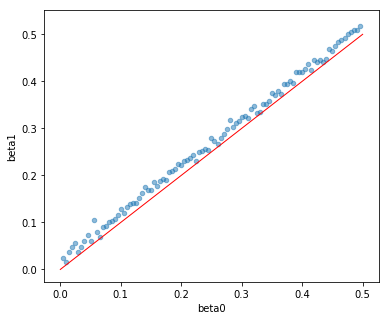

In [16]:
bmax = 0.5*K2/100
beta = np.linspace(0, bmax, 1000)
fig, ax = plt.subplots(figsize=(6, 5))
coeff.plot.scatter(x='beta0', y='beta1', ax=ax, alpha=0.5);
ax.plot(beta, beta, c='r', linewidth=1, zorder=1);

### Jax

In [5]:
from jax.config import config
config.update('jax_platform_name', 'cpu')

In [ ]:
%time table = frx.poisson(y='p', x=['x1', 'x2'], fe=['id1', 'id2'], data=df)

  0: loss = 0.5192047357559204
  1: loss = 0.5130859017372131
  2: loss = 0.512989342212677


In [10]:
coeff = table['coeff'].filter(regex='id2').rename('beta1').rename_axis('id2').reset_index()
coeff['id2'] = coeff['id2'].apply(lambda s: s[4:]).astype(np.int)
coeff['beta0'] = 0.5*coeff['id2']/100
coeff['beta1'] += table.loc['intercept', 'coeff']

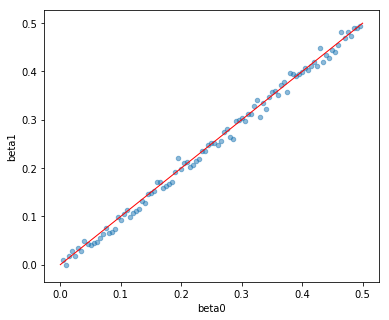

In [11]:
bmax = 0.5*K2/100
beta = np.linspace(0, bmax, 1000)
fig, ax = plt.subplots(figsize=(6, 5))
coeff.plot.scatter(x='beta0', y='beta1', ax=ax, alpha=0.5);
ax.plot(beta, beta, c='r', linewidth=1, zorder=1);